In [1]:
%load_ext autoreload
%autoreload 2
import os
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from IPython.display import Markdown as md

import generate_horndeski as gen

import cosmology as co
import cosmoGW as cosmo
import horndeski as ho
import plot_sets
import GW_analytical as an
import interferometry as inter

print(gen.__doc__)


generate_horndeski.py is a Python routine  that can be used to generate
the plots and compute the postprocessing results of Y. He, A. Roper Pol,
A. Brandenburg, "Modified propagation of gravitational waves from the early
radiation era," submitted to JCAP (2022).

It reads the pickle run variables that can be generated by the routine
initialize_horndeski.py.

The function run() executes the code.

Author: Alberto Roper Pol
created: 01/12/2022



In [2]:
# Constants of the model (note that these need to be the same as those used to solve
# Friedmann equations, generated by the cosmology_PC.ipynb notebook under the cosmology
# directory)

OmL0 = 0.6841      # Dark energy density as a fraction of present-time critical energy density
h0 = 0.6732        # Hubble rate H0 = 100 h0 km/s/Mpc
Neff = 3.          # effective number of neutrino species
g0, g0s, T0, H0, rho_rad0, OmR0 = co.values_0(h0=h0, neut=True, Neff=Neff, ret_rad=True)

#### Read the results from the Friedmann solution
print(gen.read_cosmology_results.__doc__)
a, eta, ap_a, app_a = gen.read_cosmology_results()


    Function that reads the cosmology results from the Friedmann solver
    that have already been computed using the routines under the project
    directory cosmology.
    


In [3]:
# Compute normalized variables for a chosen initial temperature
# scale
print(gen.cosmology_normalized_vars.__doc__)
T = 100*u.GeV
a_n, eta_n, HH_n, app_a_n, Omega, w, eta_n_0, aEQ_n, \
    aL_n, a_acc_n, eta_n_EQ, eta_n_L, eta_n_acc = \
        gen.cosmology_normalized_vars(a, eta, ap_a, app_a, T=T, h0=h0)
OmM0 = 1 - OmL0
Omega_mat = OmM0*a**(-3)


    Function that computes the normalized variables in terms of the solutions to
    the Friedmann solver for a specific temperature scale.
    
    Arguments:
        a -- scale factor
        eta -- conformal time
        ap_a -- conformal Hubble rate HH = a'/a
        app_a -- conformal acceleration a''/a
        T -- temperature scale (default is 100 GeV, EWPT)
        h0 -- Hubble rate at present time (default is CMB observation 67.32 km/s/Mpc)
        
    Returns:
        a_n -- normalized scale factor a/a_*
        eta_n -- normalized conformal time eta/eta_*
        HH_n -- normalized conformal Hubble rate HH/HH_*
        app_a_n -- normalized conformal acceleration (a''/a)/HH_*^2
        Omega -- ratio of energy density to critical energy at present time
        w -- equation of state
        eta_n_0 -- normalized conformal present time eta_0/eta_*
        aEQ_n -- normalized scale factor at equipartition aEQ/a_*
        aL_n -- id at dark-energy domination
        a_acc_n -

In [4]:
### cut the normalized variables between the time of GW generation
### and the present time

print(co.norm_variables_cut.__doc__)
eta_nn, HH_nn, a_nn, Omega_nn, Omega_mat_nn, app_nn, w_nn = \
        co.norm_variables_cut(eta_n, HH_n, a_n, Omega, Omega_mat, 
                              eta_n_0, T=T, OmM0=OmM0, h0=h0)


    Function that cuts the normalized variables between the initial time \eta/\eta_* = 1
    to present-time.
    
    Arguments:
        eta_n -- normalized conformal time eta/eta_*
        HH_n -- normalized conformal Hubble rate H/H_*
        a_n -- normalized scale factor a/a_*
        Omega -- ratio of total energy to present-time critical energy denstiy
        Om_mat -- matter energy density (normalized)
        eta_n_0 -- normalized conformal present time
        Hs -- Hubble rate at the initial time
        ast -- scale factor at the initial time
        T -- temperature scale at the initial time in energy units
             (default is 100 GeV)
        OmM0 -- present-time content of matter (default is 0.3159)
        h0 -- present-time value of the Hubble rate H0 = h0 x 100 km/s/Mpc
              (default is 67.32 km/s/Mpc based on CMB observations)
              
    Returns: variables given as arrays from the initial time until present time
        eta_nn -- normalized co


    Function that plots the cosmological time evolution of the alphaM parameterizations.
    
    It generates the plots corresponding to figure 1 of
    Y. He, A. Roper Pol, and A. Brandenburg, "Modified propagation of
    gravitational waves from the early radiation era," submitted to JCAP (2022).
    
    Figures saved in 'plots/alphaM_params_EWPT.pdf' and 'plots/params_WKB_lims_EWPT.pdf'
    


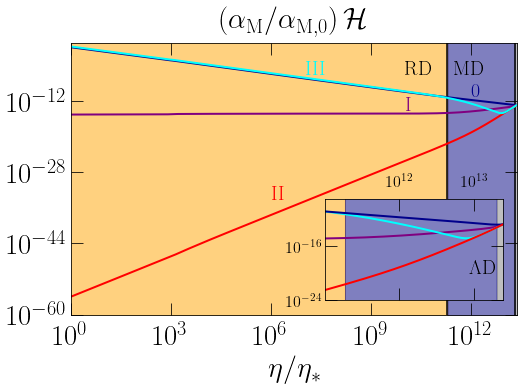

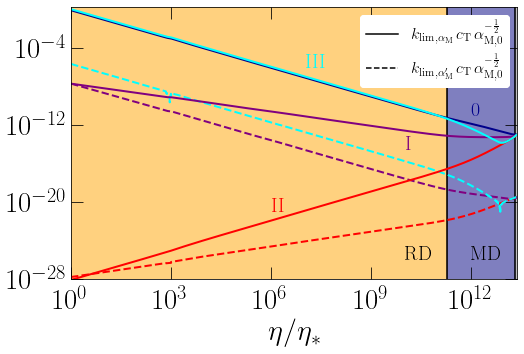

In [5]:
print(gen.plot_parameterizations_alpM.__doc__)

gen.plot_parameterizations_alpM(eta_n, a, Omega, Omega_mat, HH_n, eta_n_EQ, eta_n_acc, eta_n_0, OmM0,
                                comp_exp=1, nn_exp=1, save=True, figg=1,
                                primes=False, n2=False, n04=False, n1=True)

gen.plot_parameterizations_alpM(eta_n, a, Omega, Omega_mat, HH_n, eta_n_EQ, eta_n_acc, eta_n_0, OmM0,
                                comp_exp=1, nn_exp=1, save=True, figg=2,
                                primes=False, n2=False, n04=False, n1=True)


    Function that plots the spectra obtained using the WKB approximation
    in modified gravity for an initial GW background following a smoothed
    double broken power law.
    
    It generates the plots corresponding to figure 2 of
    Y. He, A. Roper Pol, and A. Brandenburg, "Modified propagation of
    gravitational waves from the early radiation era," submitted to JCAP
    (2022).
    
    Figures saved in 'plots/spectrum_WKB_late_times.pdf', 'plots/spectrum_WKB_normalized.pdf'
    


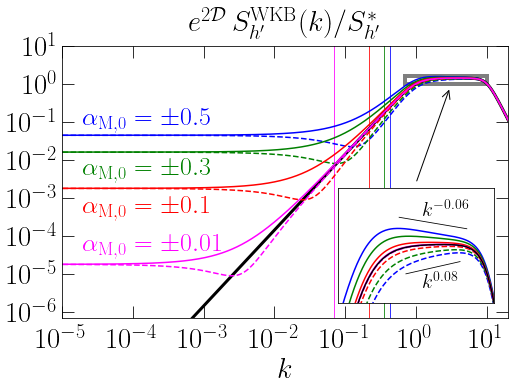

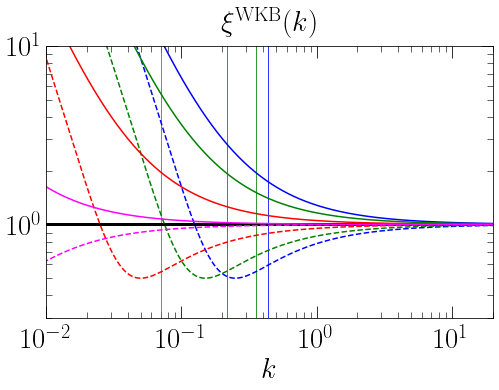

In [6]:
#### Spectra computed at late times from the WKB approximation
print(gen.plot_late_time_WKB.__doc__)
gen.plot_late_time_WKB(save=True)

In [7]:
#### compute the functions D = .5 \int \alpM HH d \eta for
#### the different choices of \alpM parameterizations

# set rd to False the first time to compute and save the variables and
# then to True to read the saved variables (faster)
print(gen.time_evolution_WKB.__doc__)
rd = True

gS = co.thermal_g(T=T, s=1)
ast = co.as_a0_rat(T=T, g=gS)

DDs_0, DDs_I, DDs_I_n04, DDs_I_n2, DDs_II, DDs_III = \
        gen.time_evolution_WKB(eta_nn, HH_nn, a_nn, ast, Omega_nn,
                               OmM0, Omega_mat_nn, read=rd, save=True)


    Function that computes the D = .5 int alpM HH d eta integral
    for the different choices of alphaM parameterization that appears
    in the WKB approximation for the increase in GW energy density.
    
    Reference: Y. He, A. Roper Pol, A. Brandenburg, "Modified propagation of
    gravitational waves from the early radiation era," submitted to JCAP (2022).
    
    If read is False, it computes D and stores it as a pickle variable in
    'WKB/DDs.pkl', otherwise it directly reads it.
    



    Function that plots the time evolution of the GW energy density from
    the numerical simulations and using the WKB approximation in modified
    gravity.
    
    It generates the plots corresponding to figure 3 of
    Y. He, A. Roper Pol, and A. Brandenburg, "Modified propagation of
    gravitational waves from the early radiation era," submitted to JCAP (2022).
    
    Figures saved in 'plots/time_series_EEGW_choice'#'.pdf'
    
Saving figure plots/time_series_EEGW_choice0.pdf
Saving figure plots/time_series_EEGW_choiceI.pdf
Saving figure plots/time_series_EEGW_choiceII.pdf
Saving figure plots/time_series_EEGW_choiceIII.pdf


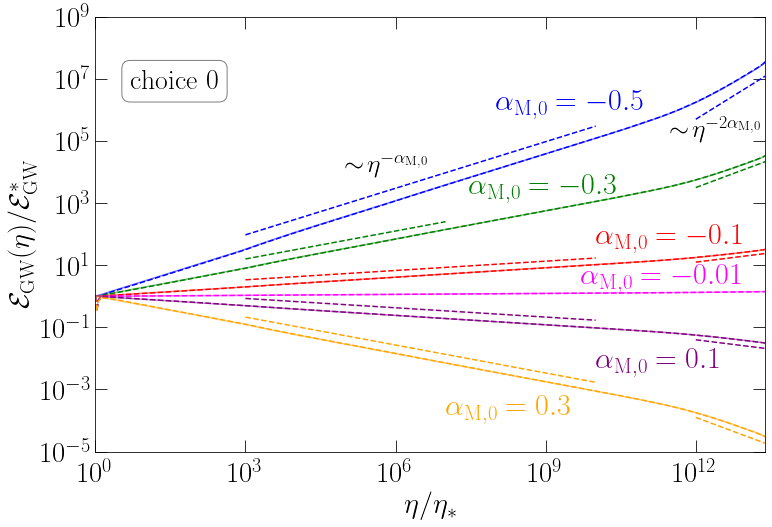

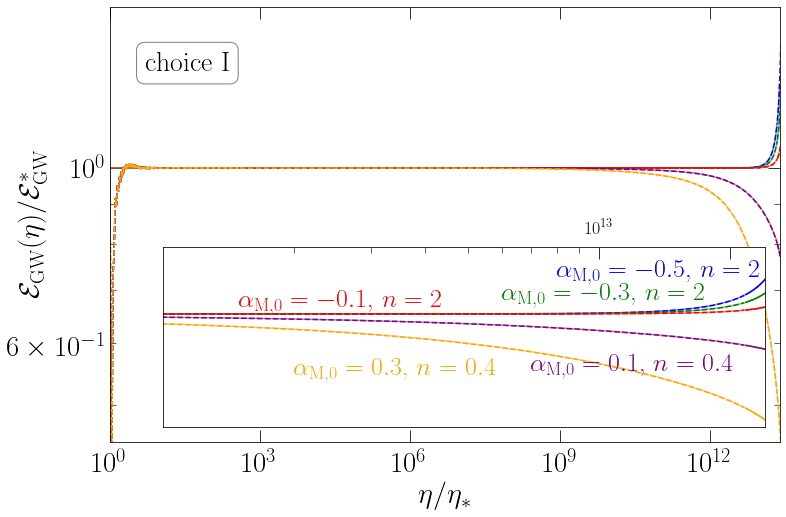

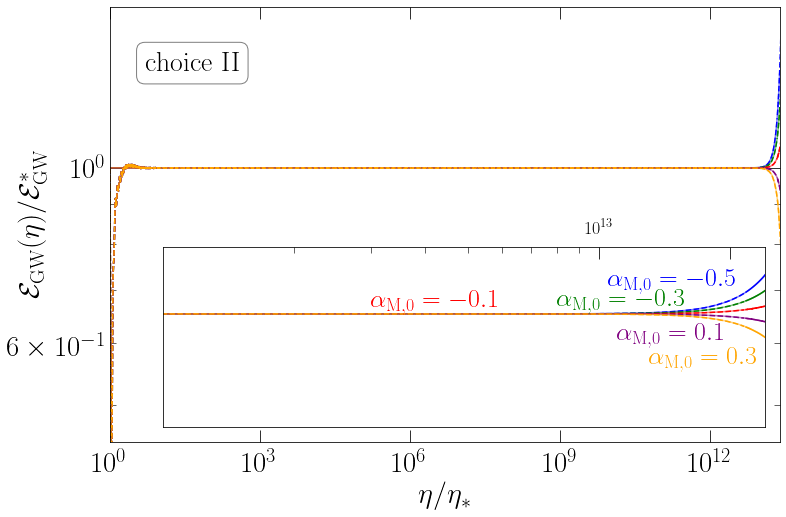

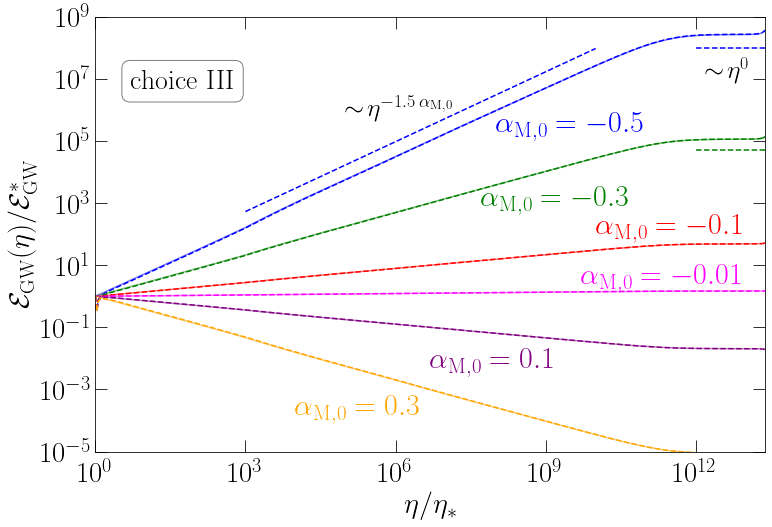

In [11]:
### plot time series of the GW energy density for the different choices
### once it has been run once and the results are saved, one can execute the
### function without reading the results from the run by setting rd = True
### the first time one needs to read the runs and set rd = False

print(gen.plot_time_evolution_EGW.__doc__)

rd = True

gen.plot_time_evolution_EGW(DDs_0, eta_nn, value0=False, choice='0', quiet=True,
                            txt=True, save=True, save_pl=True, plot=True, read=rd)
gen.plot_time_evolution_EGW(DDs_I_n2, eta_nn, value0=False, choice='I', quiet=True,
                            DDs2=DDs_I_n04, txt=True, save=True, save_pl=True, plot=True,
                            read=rd)
gen.plot_time_evolution_EGW(DDs_II, eta_nn, value0=False, choice='II', quiet=True,
                            txt=True, save=True, save_pl=True, plot=True, read=rd)
gen.plot_time_evolution_EGW(DDs_III, eta_nn, value0=False, choice='III', quiet=True,
                            txt=True, save=True, save_pl=True, plot=True, read=rd)


    Function that plots the error of the time evolution of the GW energy
    density computed using the WKB approximation in modified gravity,
    compared to the results from numerical simulations.
    
    It generates the plots corresponding to figure 4 of
    Y. He, A. Roper Pol, and A. Brandenburg, "Modified propagation of
    gravitational waves from the early radiation era,"
    submitted to JCAP (2022).
    
    It requires to first generate the results for the time series
    using plot_time_evolution_EGW
    
    Figures saved in 'plots/time_series_alpM_choice#_error_WKB.pdf'
    
Saving figure plots/time_series_alpM_choice0_error_WKB.pdf
Saving figure plots/time_series_alpM_choiceI_error_WKB.pdf
Saving figure plots/time_series_alpM_choiceII_error_WKB.pdf
Saving figure plots/time_series_alpM_choiceIII_error_WKB.pdf


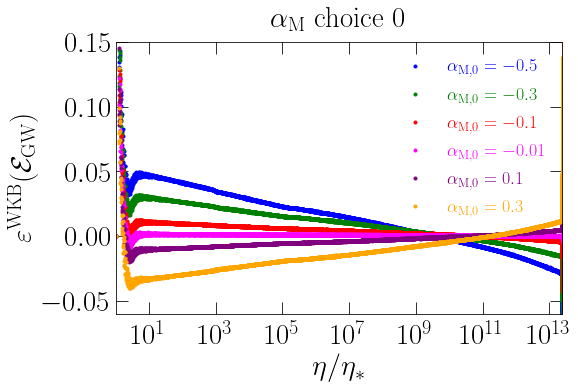

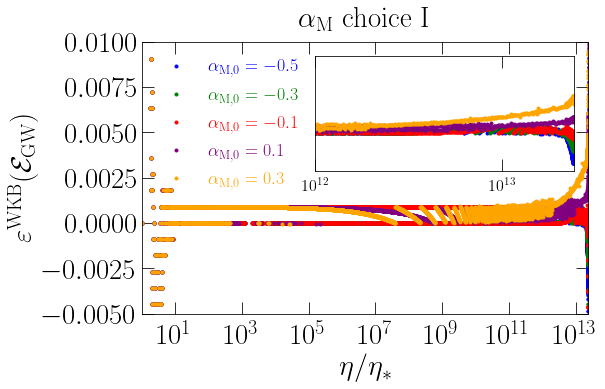

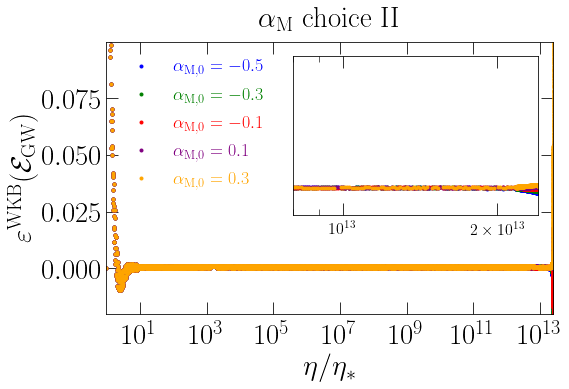

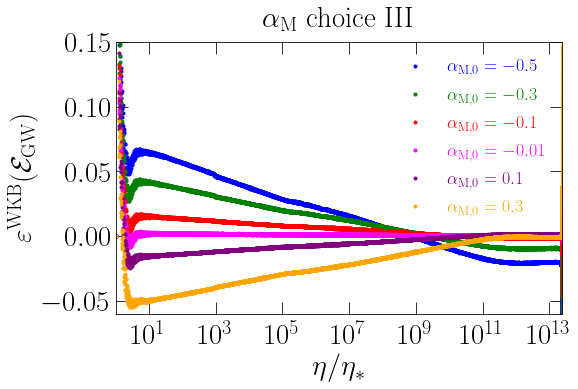

In [12]:
### plot time series of the WKB error in the GW energy density
### for the different choices

print(gen.plot_time_series_error_WKB.__doc__)

gen.plot_time_series_error_WKB(DDs_0, eta_nn, choice='0')
gen.plot_time_series_error_WKB(DDs_I_n2, eta_nn, DDs2=DDs_I_n04, choice='I')
gen.plot_time_series_error_WKB(DDs_II, eta_nn, choice='II')
gen.plot_time_series_error_WKB(DDs_III, eta_nn, choice='III')

In [15]:
##### compute spectra (average, envelope) by combining the 4 different
##### runs and save the results as a pickle variable, it can be just loaded
##### after running once by setting rd = True

print(gen.compute_all_spectra.__doc__)

## choice 0
rd = True
neg_alpM_sp_ch0, pos_alpM_sp_ch0 = \
        gen.compute_all_spectra(eta_nn, HH_nn, a_nn, Omega_nn, Omega_mat_nn, OmM0, DDs_0,
                                ch='0', save=True, read=rd)
## choice III
neg_alpM_sp_chIII, pos_alpM_sp_chIII = \
        gen.compute_all_spectra(eta_nn, HH_nn, a_nn, Omega_nn, Omega_mat_nn, OmM0, DDs_III,
                                ch='III', save=True, read=rd)

## choice I
neg_alpM_sp_chI, pos_alpM_sp_chI = \
        gen.compute_all_spectra(eta_nn, HH_nn, a_nn, Omega_nn, Omega_mat_nn, OmM0, DDs_I_n2,
                                DDs2=DDs_I_n04, ch='I', save=True, read=rd)

## choice II
neg_alpM_sp_chII, pos_alpM_sp_chII = \
        gen.compute_all_spectra(eta_nn, HH_nn, a_nn, Omega_nn, Omega_mat_nn, OmM0, DDs_II,
                                ch='II', save=True, read=rd)


    Function that computes all spectra for a specific choice of alpM parameterization:
        '0', 'I', 'II' or 'III'
    It returns the results for the different values of alpM0: 'A' to 'F' (choices 0 or III)
    or 'A' to 'E' (choices I and II).
    It returns separately the results for positive and negative values of alpM
    
    If save = True and read = False, then it computes the spectra and saves the results in
            'results/pos_alpM_sp_ch#ch.pkl'
    
    If read = True, then it reads the already computed results.
    
Reading results from pickle variable results/neg_alpM_sp_ch0.pkl
Reading results from pickle variable results/pos_alpM_sp_ch0.pkl
Reading results from pickle variable results/neg_alpM_sp_chIII.pkl
Reading results from pickle variable results/pos_alpM_sp_chIII.pkl
Reading results from pickle variable results/neg_alpM_sp_chI.pkl
Reading results from pickle variable results/pos_alpM_sp_chI.pkl
Reading results from pickle variable results/neg_alpM_sp_chII.p


    Function that computes the spectra combining the 4 runs for all cases A to D
    for choices 0 and III (negative values of alpha_M)
    It uses the numerical spectra to obtain the envelope over oscillations
    at each wave number and compensates by the total growth in the GW
    energy density obtained (and verified) from the WKB approximation.
    It also returns the WKB estimated spectra at late times.
    
    It generates the plots corresponding to figure 5 of
    Y. He, A. Roper Pol, and A. Brandenburg, "Modified propagation of
    gravitational waves from the early radiation era,"
    submitted to JCAP (2022).
    
    Figure saved in 'plots/spectra_envelope_choices_0_III.pdf'
    
Saving figure in plots/spectra_envelope_choices_0_III.pdf


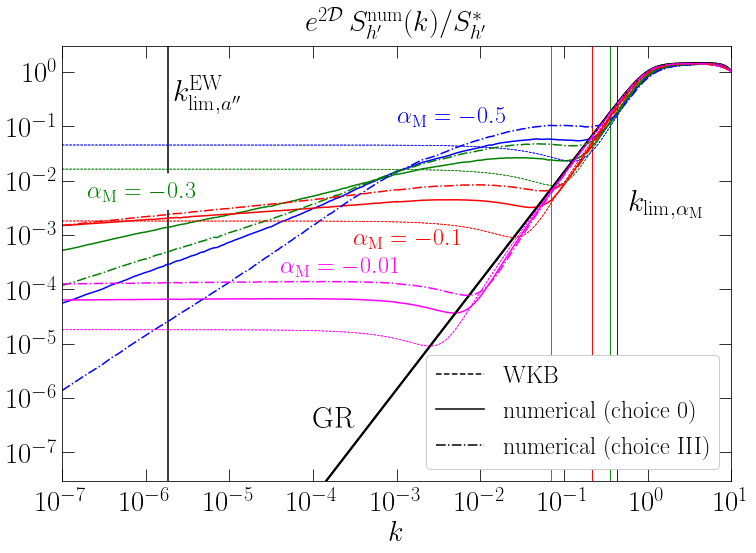

In [16]:
print(gen.plot_all_spectra.__doc__)
gen.plot_all_spectra(neg_alpM_sp_ch0, app=app_nn[0], ch='0', save=False,
                           newf=True, lss='solid', txt=True, fact=3.5e-10)
gen.plot_all_spectra(neg_alpM_sp_chIII, app=app_nn[0], ch='III', save=True,
                           newf=False, lss='-.', txt=True, fact=3.5e-10)